In [1]:
import requests
from bs4 import BeautifulSoup as soup
import json
import pandas as pd
import numpy as np
import mplsoccer
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# SCRAPING FROM UNDERSTAT

def scrap_understat(player_id):
    base_url = 'https://understat.com/player/'
    url = base_url+str(player_id)

    req = requests.get(url)
    parse_soup = soup(req.content, 'lxml')
    scripts = parse_soup.find_all('script')
    
    strings = scripts[3].string

    ind_start = strings.index("('") + 2
    ind_end = strings.index("')")

    json_data = strings[ind_start:ind_end]
    json_data = json_data.encode('utf8').decode('unicode_escape')

    data = json.loads(json_data)

    shotType = []
    season = []
    result = []
    player = []
    situation = []
    
    for index in range(len(data)):
        for key in data[index]:
            if key=='shotType':
                shotType.append(data[index][key])
            if key=='season':
                season.append(data[index][key])
            if key=='result':
                result.append(data[index][key])
            if key=='player':
                player.append(data[index][key])
            if key=='situation':
                situation.append(data[index][key])

    cols = ['Player', 'shotType','result','Season', 'Situation']
    df = pd.DataFrame([player, shotType, result,season, situation], index=cols)
    df = df.T
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df[df['Season']==2020]
    df = df[df['Situation']!='Penalty'].reset_index(drop=True)
    
    return df

In [3]:
index = ['227','2097','8260','2371','2370','3423','6170','1229','647','5169','594','2098','7052']

In [4]:
df = pd.DataFrame(columns=['Player', 'shotType','result','Season', 'Situation'])

for i in index:
    df = pd.concat([df,scrap_understat(i)])

In [5]:
df
df[df['shotType'].apply(lambda x: x not in ('RightFoot','LeftFoot', 'Head'))]

,Player,shotType,result,Season,Situation
98,Lionel Messi,OtherBodyPart,MissedShots,2020,OpenPlay
88,Romelu Lukaku,OtherBodyPart,Goal,2020,OpenPlay
30,Wout Weghorst,OtherBodyPart,MissedShots,2020,FromCorner
70,Wout Weghorst,OtherBodyPart,MissedShots,2020,SetPiece


In [6]:
players = [name for name in df['Player'].unique()]
players

['Robert Lewandowski',
 'Lionel Messi',
 'Erling Haaland',
 'Cristiano Ronaldo',
 'Karim Benzema',
 'Kylian Mbappe-Lottin',
 'André Silva',
 'Luis Muriel',
 'Harry Kane',
 'Youssef En-Nesyri',
 'Romelu Lukaku',
 'Luis Suárez',
 'Wout Weghorst']

In [7]:
len(df[(df['Player']==players[0]) & (df['result']=='Goal')])

33

In [8]:
df_shot = pd.DataFrame(columns=['Player', 'Right%','Left%','Head%', 'Count', 'Goals'])
df_shot

for name in players:
    shot_dict = df[df['Player']==name]['shotType'].value_counts().to_dict()
    total_shots = len(df[df['Player']==name])
    total_goals = len(df[(df['Player']==name) & (df['result']=='Goal')])
    player_shot = pd.DataFrame(np.array([[name, shot_dict['RightFoot']*100/total_shots, 
                       shot_dict['LeftFoot']*100/total_shots, shot_dict['Head']*100/total_shots,
                                 total_shots, total_goals]]),
                       columns=['Player', 'Right%','Left%','Head%', 'Count', 'Goals'])
    df_shot = pd.concat([df_shot, player_shot]).reset_index(drop=True)

In [9]:
df_shot = df_shot.apply(pd.to_numeric, errors='ignore')

In [10]:
df_shot = df_shot.set_index('Player')

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns

from highlight_text import ax_text,fig_text

background = '#1E1F21'
text_color = 'white'
mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['text.color']=text_color
mpl.rcParams['font.family']='Calibri'
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['legend.fontsize'] = 16

Text(0.875, 0.977, 'khatri_shreyas')

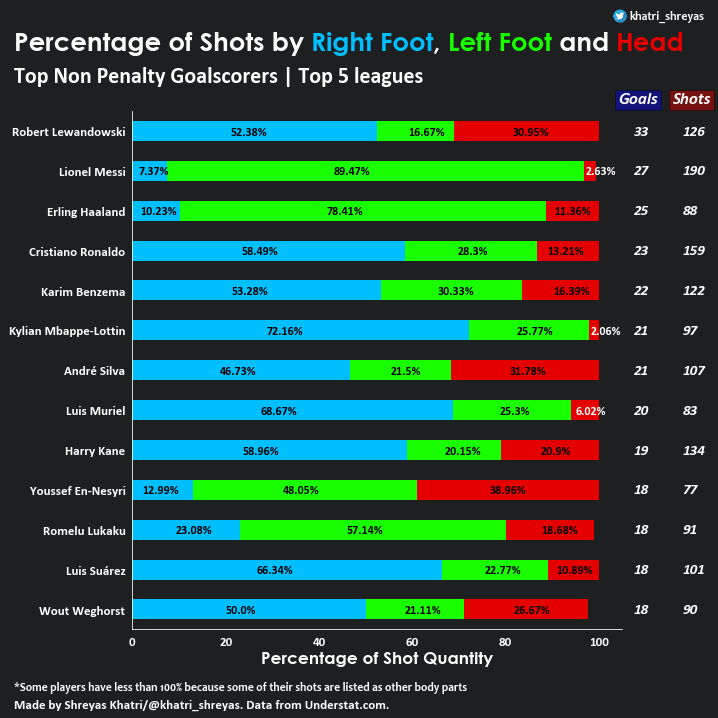

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor(background)
ax.axis('off')

ax = fig.add_axes([0.185,0.13,0.68,0.72])
ax.patch.set_facecolor(background)

for s in ['top','right']:
    ax.spines[s].set_visible(False)
    
for s in ['left','bottom']:
    ax.spines[s].set_color('white')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

p = df_shot[['Right%','Left%','Head%']].plot(kind='barh', ax=ax, stacked = True, legend=False,
                                        color=['#00BFFF', '#1AFF00', '#E50000'])
p.set_xlabel('Percentage of Shot Quantity', 
             color=text_color, size = 17, family='Century Gothic', weight = 'bold')
p.set_ylabel('')

for en, i in enumerate(ax.patches):
    if i.xy[0] > 92:
        plt.text(i.xy[0] + i.get_width()/6, i.get_y()+0.35,
             str(round(i.get_width(),2)) + '%',
             fontsize = 12, fontweight ='bold',
             color ='white')
    elif (i.get_width()<15):
        plt.text(i.xy[0] + i.get_width()/6, i.get_y()+0.35,
             str(round(i.get_width(),2)) + '%',
             fontsize = 12, fontweight ='bold',
             color ='black')
    else:
        plt.text(i.xy[0] + i.get_width()/2.5, i.get_y()+0.35,
             str(round(i.get_width(),2)) + '%',
             fontsize = 12, fontweight ='bold',
             color ='black')

for en, i in enumerate(ax.patches):
    plt.text(118,i.get_y()+0.35,
            str(int(df_shot.iloc[en]['Count'])),
            fontsize = 15, fontweight ='heavy', style='italic')
    if en == 12: break
fig.text(0.935,0.86,'Shots', size=17, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.4, 'pad': 3})

for en, i in enumerate(ax.patches):
    plt.text(107.5,i.get_y()+0.35,
            str(int(df_shot.iloc[en]['Goals'])),
            fontsize = 15, fontweight ='heavy', style='italic')
    if en == 12: break
fig.text(0.86,0.86,'Goals', size=17, style='italic',
        bbox={'facecolor': 'blue', 'alpha': 0.4, 'pad': 3})
ax.invert_yaxis()

plt.tight_layout()

# TITLES AND LABELS
fig_text(0.02,0.96,'Percentage of Shots by <Right Foot>, <Left Foot> and <Head>', size = 26, weight='heavy',
        family='Century Gothic',
        highlight_textprops=[{'color':'#00BFFF'},{'color':'#1AFF00'},{'color':'#E50000'}])
fig.text(0.02,0.89,'Top Non Penalty Goalscorers | Top 5 leagues', 
         size = 22)
fig.text(0.02,0.045,'*Some players have less than 100% because some of their '+
         'shots are listed as other body parts', fontdict = dict(family='Candara'), size=11.5)
fig.text(0.02,0.02,'Made by Shreyas Khatri/@khatri_shreyas. Data from Understat.com.', 
         size=13)

ax2 = fig.add_axes([0.85,0.97,0.025,0.025])
ax2.axis('off')
img = plt.imread('twitter.png')
ax2.imshow(img)
fig.text(0.875,0.977,'khatri_shreyas', size=12, weight='bold', family='Candara')

#plt.savefig('Images/Shots_Quantity', facecolor=background, dpi=300)